In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, root_mean_squared_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (assuming you have a CSV file named 'haber_bosch_dataset.csv')
data = pd.read_csv('haber_bosch_dataset1.csv')

# Prepare the features and target variables
X = data[['temperature', 'pressure', 'h2_n2_ratio', 'catalyst_age', 'space_velocity']]
y_conversion = data['conversion']
y_fault = data['fault']

# Split the data
X_train, X_test, y_conv_train, y_conv_test, y_fault_train, y_fault_test = train_test_split(
    X, y_conversion, y_fault, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implement SVC for fault detection
svc_model = SVC(random_state=42)

# Hyperparameter tuning for SVC
svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 1]
}
svc_grid_search = GridSearchCV(svc_model, svc_param_grid, cv=5, n_jobs=-1)
svc_grid_search.fit(X_train_scaled, y_fault_train)

# Best SVC model
best_svc = svc_grid_search.best_estimator_

# Predict and evaluate SVC model
y_fault_pred = best_svc.predict(X_test_scaled)
fault_accuracy = accuracy_score(y_fault_test, y_fault_pred)
print(f"Fault Detection Accuracy: {fault_accuracy}")
print("\nClassification Report:")
print(classification_report(y_fault_test, y_fault_pred))

# Implement SVR for conversion prediction
svr_model = SVR()

# Hyperparameter tuning for SVR
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2]
}
svr_grid_search = GridSearchCV(svr_model, svr_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train_scaled, y_conv_train)

# Best SVR model
best_svr = svr_grid_search.best_estimator_

# Predict and evaluate SVR model
y_conv_pred = best_svr.predict(X_test_scaled)
conv_mse = root_mean_squared_error(y_conv_test, y_conv_pred)
print(f"\nConversion Prediction MSE: {conv_mse}")




Fault Detection Accuracy: 0.915

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       119
           1       0.86      0.94      0.90        81

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200



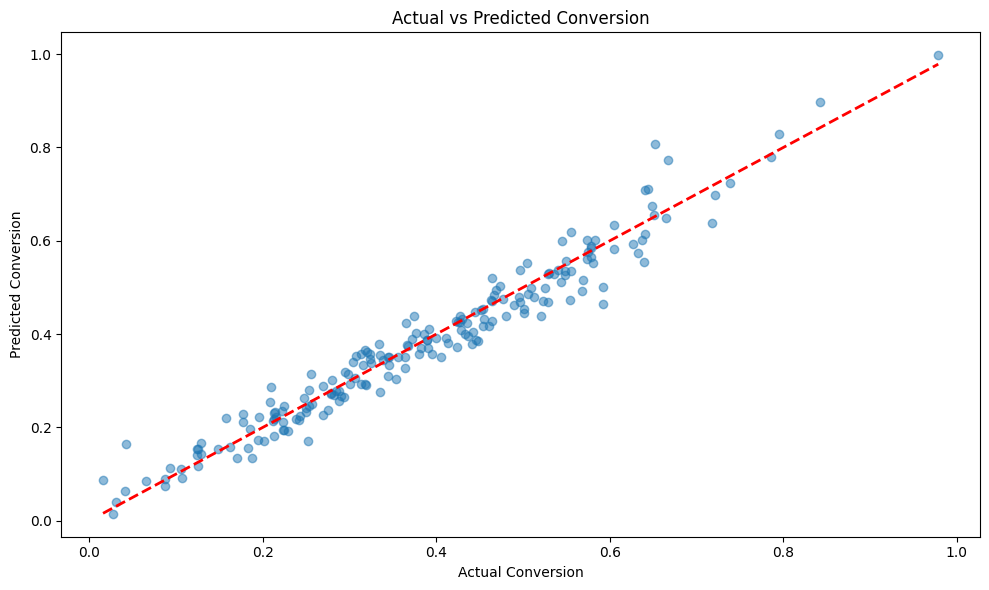

In [4]:
# Visualize actual vs predicted conversion
plt.figure(figsize=(10, 6))
plt.scatter(y_conv_test, y_conv_pred, alpha=0.5)
plt.plot([y_conv_test.min(), y_conv_test.max()], [y_conv_test.min(), y_conv_test.max()], 'r--', lw=2)
plt.xlabel('Actual Conversion')
plt.ylabel('Predicted Conversion')
plt.title('Actual vs Predicted Conversion')
plt.tight_layout()
plt.show()

In [5]:
# Feature importance for SVC (using absolute values of coefficients for linear kernel)
if best_svc.kernel == 'linear':
    svc_importance = np.abs(best_svc.coef_[0])
    svc_features = X.columns
    svc_importance_df = pd.DataFrame({'feature': svc_features, 'importance': svc_importance})
    svc_importance_df = svc_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=svc_importance_df)
    plt.title('Feature Importance for Fault Detection (SVC)')
    plt.tight_layout()
    plt.show()

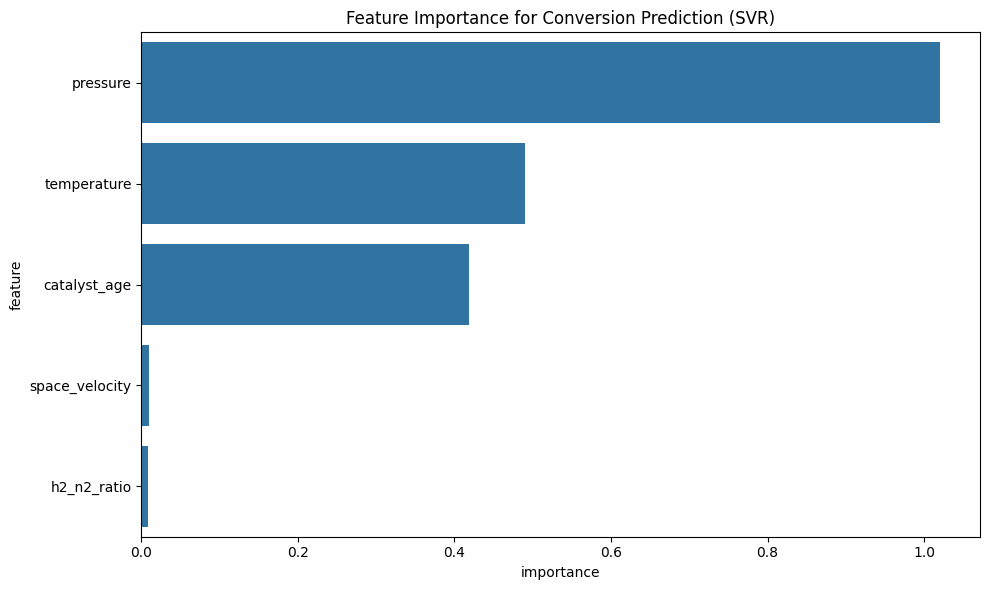

In [6]:
# For SVR, we can't directly get feature importance, but we can use permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_svr, X_test_scaled, y_conv_test, n_repeats=10, random_state=42)
svr_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
svr_importance_df = svr_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=svr_importance_df)
plt.title('Feature Importance for Conversion Prediction (SVR)')
plt.tight_layout()
plt.show()

In [7]:
print("\nBest parameters for SVC:", svc_grid_search.best_params_)
print("Best parameters for SVR:", svr_grid_search.best_params_)


Best parameters for SVC: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for SVR: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}


In [9]:
from joblib import dump, load
dump(best_svc, 'best_svc.joblib')
dump(best_svr, 'best_svr.joblib')

['best_svr.joblib']